## Observations and Insights 

Below I've investigated the two datasets after merging them into one PandDataframe and then cleaning the data. After plotting and calculating this data I have concluded that:
- there is somewhat of a medium correlation between the Tumor Volume and Weight, further plotting them reveals that there is no clear correlation between them
- out of the six outliers 5 are female and only 1 is male. Of these 5 females, 4 are considerable younger than the other 2 mice. And these 4 are under the following Drug Regimen 
        - Propriva x 2(both above are the upper_bound of tumor volume)
        - Capomulin x 2(both are below lower_bound of tumor volume) 
- There is an even distribution of male vs female mice
- Ramicane and Capomulin have the heighest total number of timpoints
- Capomulin may have the best result but that would need further investigations

In [190]:
# Dependencies and Setup
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
import scipy.stats as st
import random
import numpy as np
import seaborn as sns
%matplotlib inline

In [193]:
# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)


In [194]:

# Combine the data into a single dataset

mouse_data_complete = pd.merge(mouse_metadata, study_results, how='left', on=['Mouse ID','Mouse ID'])

# Display the data table for preview

mouse_data_complete

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [195]:
# Checking the number of mice.
total_mice = mouse_data_complete['Mouse ID'].nunique()
total_mice

249

In [196]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
mouse_data_duplicates = mouse_data_complete.duplicated(subset=['Mouse ID','Timepoint'])

mouse_data_duplicates

0       False
1       False
2       False
3       False
4       False
        ...  
1888    False
1889    False
1890    False
1891    False
1892    False
Length: 1893, dtype: bool

In [197]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
mouse_data_complete.loc[mouse_data_duplicates]

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [198]:
# Optional: Get all the data for the duplicate mouse ID. 

mouse_data_complete.loc[mouse_data_duplicates]

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [199]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mouse_data_post_drop_duplicates = mouse_data_complete.drop_duplicates(subset=['Mouse ID','Timepoint'],inplace=False)
mouse_data_complete = mouse_data_post_drop_duplicates
mouse_data_complete

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [200]:
# Checking the number of mice in the clean DataFrame.
total_mice_clean = mouse_data_complete['Mouse ID'].nunique()
total_mice_clean

249

## Summary Statistics

In [201]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.

drug_regimen_statistics = mouse_data_complete.groupby('Drug Regimen')
drug_regimen_mean = drug_regimen_statistics['Tumor Volume (mm3)'].mean()
drug_regimen_median = drug_regimen_statistics['Tumor Volume (mm3)'].median()
drug_regimen_variance = drug_regimen_statistics['Tumor Volume (mm3)'].var()
drug_regimen_stdev = drug_regimen_statistics['Tumor Volume (mm3)'].std()
drug_regimen_SEM = drug_regimen_statistics['Tumor Volume (mm3)'].sem()
tumor_volume_summary = pd.DataFrame({'Tumor Volume (Mean)': drug_regimen_mean,
                                     'Tumor Volume (Median)': drug_regimen_median,
                                     'Tumor Volume (Variance)':drug_regimen_variance,
                                     'Tumor Volume (Standard Deviation)':drug_regimen_stdev,
                                     'Tumor Volume (SEM)':drug_regimen_SEM 
                                     })

tumor_volume_summary.head()


,Tumor Volume (Mean),Tumor Volume (Median),Tumor Volume (Variance),Tumor Volume (Standard Deviation),Tumor Volume (SEM)
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466


In [202]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
tumor_summary_single = pd.DataFrame({'Tumor Volume (Mean)': drug_regimen_statistics['Tumor Volume (mm3)'].mean(),
                                     'Tumor Volume (Median)': drug_regimen_statistics['Tumor Volume (mm3)'].median(),
                                     'Tumor Volume (Variance)': drug_regimen_statistics['Tumor Volume (mm3)'].var(),
                                     'Tumor Volume (Standard Deviation)':drug_regimen_statistics['Tumor Volume (mm3)'].std(),
                                     'Tumor Volume (SEM)': drug_regimen_statistics['Tumor Volume (mm3)'].sem() 
                                     })

tumor_summary_single.head()

,Tumor Volume (Mean),Tumor Volume (Median),Tumor Volume (Variance),Tumor Volume (Standard Deviation),Tumor Volume (SEM)
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466


## Bar and Pie Charts

<AxesSubplot:xlabel='Drug Regimen'>

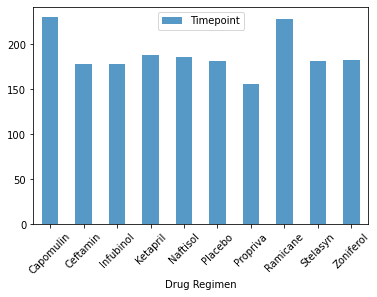

In [203]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
total_timepoints = mouse_data_complete[['Drug Regimen', 'Timepoint']].groupby('Drug Regimen').count()
total_timepoints

total_timepoints.plot(kind='bar', legend=True,alpha=0.75, rot=45)

In [204]:
total_timepoints=total_timepoints.reset_index(0)
total_timepoints

,Drug Regimen,Timepoint
0,Capomulin,230
1,Ceftamin,178
2,Infubinol,178
3,Ketapril,188
4,Naftisol,186
5,Placebo,181
6,Propriva,156
7,Ramicane,228
8,Stelasyn,181
9,Zoniferol,182


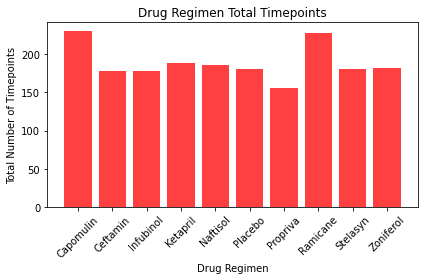

In [205]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
plt.bar(total_timepoints['Drug Regimen'],total_timepoints['Timepoint'], facecolor="red", alpha=0.75, align="center")
plt.xticks(total_timepoints['Drug Regimen'],rotation=45)
plt.title('Drug Regimen Total Timepoints')
plt.xlabel('Drug Regimen')
plt.ylabel('Total Number of Timepoints')
plt.tight_layout()
plt.show()

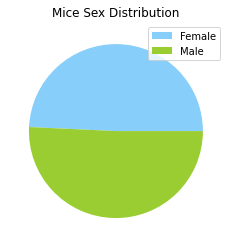

In [206]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
mouse_by_sex = mouse_data_complete.groupby("Sex")
mouse_by_sex = mouse_by_sex['Sex'].count()
mouse_by_sex.plot(kind='pie',colors=['lightskyblue','yellowgreen'], 
                  legend=True,title='Mice Sex Distribution', ylabel='',
                  labeldistance=None)
plt.show()

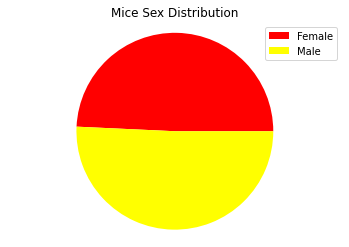

In [212]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.title('Mice Sex Distribution')
plt.pie(mouse_by_sex, colors=['red','yellow'])
labels= ['Female', 'Male']
plt.legend( labels, loc="best")
plt.axis("equal")
plt.show()

## Quartiles, Outliers and Boxplots

In [219]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
# Start by getting the last (greatest) timepoint for each mouse
mouse_Data_filtered = mouse_data_complete.loc[mouse_data_complete['Drug Regimen'].isin(['Ramicane','Capomulin','Infubinol','Ceftamin'])]
grouped_data = mouse_Data_filtered.groupby(['Drug Regimen','Mouse ID'])


grouped_data['Timepoint','Tumor Volume (mm3)'].max()



/Applications/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Timepoint  Tumor Volume (mm3)
Drug Regimen Mouse ID                               
Capomulin    b128             45           45.651331
             b742             45           45.000000
             f966             20           45.000000
             g288             45           46.304003
             g316             45           46.809225
...                          ...                 ...
Ramicane     s508             45           45.000000
             u196             45           47.622816
             w678              5           45.000000
             y449             15           46.378092
             z578             45           45.000000

[100 rows x 2 columns]

In [214]:
# Put treatments into a list for for loop (and later for plot labels)
treatments = mouse_data_complete['Drug Regimen'].unique()

# Create empty list to fill with tumor vol data (for plotting)
tumor_vol_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
q1 = mouse_data_complete.groupby('Drug Regimen')['Tumor Volume (mm3)'].quantile(.25)
q3 = mouse_data_complete.groupby('Drug Regimen')['Tumor Volume (mm3)'].quantile(.75)  
iqr = (q3-q1)
upper_bound = q3 + 1.5*iqr
lower_bound = q1 - 1.5*iqr

 # Determine outliers using upper and lower bounds
    
tumor_outliers = {'Drug Regimen': (q3-q1).index.values, 'upper_bound': upper_bound.values, 'lower_bound': lower_bound.values}
outliers = pd.DataFrame(tumor_outliers)

mouse_data_complete_copy = mouse_data_complete.copy()
mouse_data_complete_copy = mouse_data_complete.merge(outliers, on = 'Drug Regimen', how = 'outer')



lower_outliers = mouse_data_complete_copy.loc[(mouse_data_complete_copy['Tumor Volume (mm3)'] < mouse_data_complete_copy['lower_bound'])]
upper_outliers = mouse_data_complete_copy.loc[(mouse_data_complete_copy['Tumor Volume (mm3)'] > mouse_data_complete_copy['upper_bound'])]

outliers_final = pd.concat([lower_outliers, upper_outliers])
outliers_final
    

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,upper_bound,lower_bound
9,k403,Ramicane,Male,21,16,45,22.050126,1,57.488048,24.186586
236,s185,Capomulin,Female,3,17,40,25.472143,1,55.971101,26.714832
237,s185,Capomulin,Female,3,17,45,23.343598,1,55.971101,26.714832
1105,m269,Stelasyn,Female,22,28,45,75.123690,1,74.727535,32.038901
1627,o562,Propriva,Female,4,25,40,71.172463,1,70.659861,32.877792
1628,o562,Propriva,Female,4,25,45,72.455421,2,70.659861,32.877792


<IPython.core.display.Javascript object>


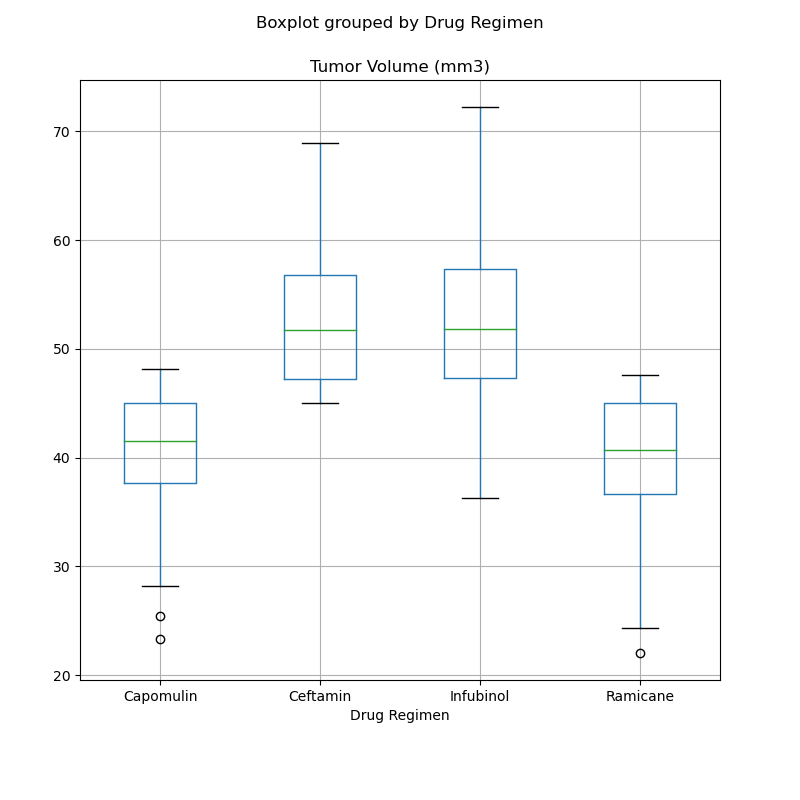

In [170]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
drug_regimen_box = mouse_Data_filtered.boxplot('Tumor Volume (mm3)', by='Drug Regimen', figsize=(8,8))


## Line and Scatter Plots

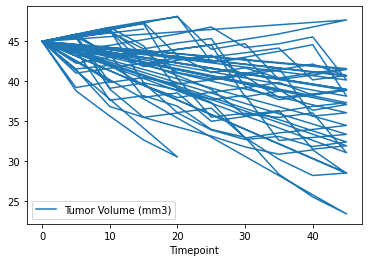

In [215]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
volume_vs_timepoint = mouse_data_complete[mouse_data_complete['Drug Regimen'] == 'Capomulin']
volume_vs_timepoint = volume_vs_timepoint[['Timepoint', 'Tumor Volume (mm3)']]
volume_vs_timepoint.plot(x='Timepoint', y='Tumor Volume (mm3)',)


plt.show()

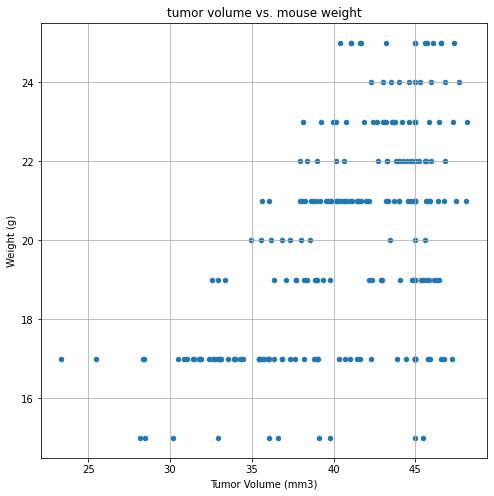

In [216]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
volume_vs_weight = mouse_data_complete[mouse_data_complete['Drug Regimen'] == 'Capomulin']
volume_vs_weight.plot(kind="scatter", x='Tumor Volume (mm3)', y='Weight (g)', grid=True, figsize=(8,8),
              title='tumor volume vs. mouse weight')
plt.show()

## Correlation and Regression

In [178]:
volume_vs_weight.corr()

,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Age_months,1.000000,-0.169172,-0.057964,-0.021604,0.006748
Weight (g),-0.169172,1.000000,-0.035271,0.525700,-0.119149
Timepoint,-0.057964,-0.035271,1.000000,-0.584271,0.584006
Tumor Volume (mm3),-0.021604,0.525700,-0.584271,1.000000,-0.313092
Metastatic Sites,0.006748,-0.119149,0.584006,-0.313092,1.000000


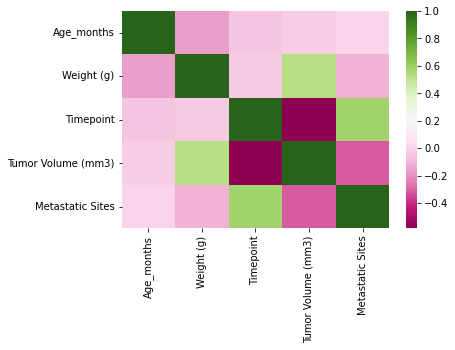

In [184]:
sns.heatmap(volume_vs_weight.corr(), cmap="PiYG")
plt.show()

<AxesSubplot:xlabel='Tumor Volume (mm3)', ylabel='Weight (g)'>

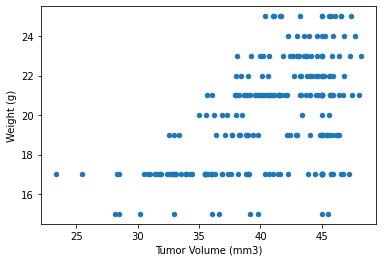

In [185]:
volume_vs_weight.plot(x="Tumor Volume (mm3)", y="Weight (g)", kind="scatter")

In [175]:
# Calculate the correlation coefficient
# for mouse weight and average tumor volume for the Capomulin regimen
round(st.pearsonr(volume_vs_weight['Tumor Volume (mm3)'], volume_vs_weight['Weight (g)'])[0],2)

0.53

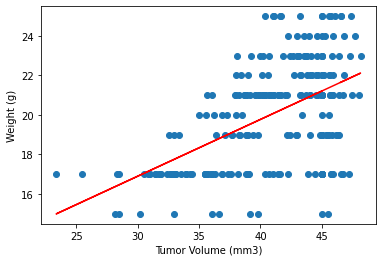

In [217]:
# And linear regression mod
x_values = volume_vs_weight['Tumor Volume (mm3)']
y_values = volume_vs_weight['Weight (g)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,'r-')
plt.xlabel('Tumor Volume (mm3)')
plt.ylabel('Weight (g)')
plt.show()